<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Sentiment analysis con Embeddings + LSTM

### Objetivo
El objetivo es utilizar las críticas de compradores de ropa para que el sistema determine la evaluación del comprador y su crítica (cuantas estrellas le asigna al producto).

## Ejercicio

- Utilizar Embeddings + LSTM para clasificar críticas de compradores de ropa.
- Deberá balancear el dataset o utilizar una métrica que tenga en cuenta el desbalance de clases.
- El accuracy de validación deberá rondar entre los 0.5 y 0.7.
- Pruebe con y sin embeddings pre-entrenados.

In [1]:
#! pip install --upgrade --no-cache-dir gdown --quiet

In [2]:
import numpy as np
import random
import io
import pickle
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.utils.np_utils import to_categorical
from tensorflow.keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding

### Datos
Utilizaremos como dataset críticas de compradores de ropa (eCommerce) los cuales puntuaron a cada prenda con un puntaje de 1 a 5 estrellas.\
Referencia del dataset: [LINK](https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews/version/1)

In [3]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('clothing_ecommerce_reviews.csv', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1Urn1UFSrodN5BuW6-sc_igtaySGRwhV8'
    output = 'clothing_ecommerce_reviews.csv'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

El dataset ya se encuentra descargado


In [4]:
# Armar el dataset
df = pd.read_csv('clothing_ecommerce_reviews.csv')
df.drop(columns = ['Unnamed: 0'], inplace = True)
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


### 1 - Limpieza de datos
Alumno:
- Del dataset unicamente utilizar las columnas "Review Text" y "Rating.
- Tranformar el rating 1-5 a una escala numérica de 0 a 4.



In [5]:
df_reviews = df.loc[:, ['Review Text', 'Rating']].dropna()
df_reviews['Rating'] = df_reviews['Rating'] - 1
df_reviews.head()

,Review Text,Rating
0,Absolutely wonderful - silky and sexy and comf...,3
1,Love this dress! it's sooo pretty. i happene...,4
2,I had such high hopes for this dress and reall...,2
3,"I love, love, love this jumpsuit. it's fun, fl...",4
4,This shirt is very flattering to all due to th...,4


Rating
5    13131
4     5077
3     2871
2     1565
1      842
Name: count, dtype: int64


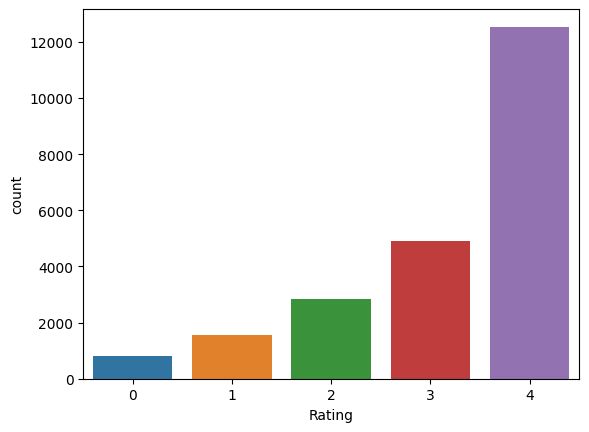

In [6]:
# Alumno: Observar como está distribuido el dataset respecto a la columna Rating
# es decir, observar que tan balanceado se encuentra respecot a cada clase

rating_counts = df['Rating'].value_counts()
print(rating_counts)

sns.countplot(x='Rating', data=df_reviews)
plt.show()

In [7]:
# Alumno: tomar la columna de las review y almacenarlo todo en un vector numpy de reviews

text_sequences = df_reviews['Review Text'].values
text_sequences.shape

(22641,)

In [8]:
# Alumno: Cuantas reviews (rows) hay para evaluar?

len(text_sequences)

22641

In [9]:
# Alumno: Concatenar todas las reviews para armar el corpus

reviews_array = text_sequences.astype(str)
corpus = ' '.join(reviews_array)

In [10]:
# Alumno: ¿Cuál es la longitud de ese corpus?
len(corpus)

7011643

In [11]:
# Alumno: Utilizar "text_to_word_sequence" para separar las palabras en tokens
# recordar que text_to_word_sequence automaticamente quita los signos de puntuacion y pasa el texto a lowercase
from keras.preprocessing.text import text_to_word_sequence

tokens = text_to_word_sequence(corpus)

In [12]:
# Alumno: Dar un vistazo a los primeros 20 tokens/palabras

tokens[:20]

['absolutely',
 'wonderful',
 'silky',
 'and',
 'sexy',
 'and',
 'comfortable',
 'love',
 'this',
 'dress',
 "it's",
 'sooo',
 'pretty',
 'i',
 'happened',
 'to',
 'find',
 'it',
 'in',
 'a']

In [13]:
# Alumno: ¿Cuántos tokens/palabras hay?

len(tokens)

1372203

In [14]:
# ! pip install spacy
# ! python -m spacy download en

In [15]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

# filtramos los tokens que sean stop words
tokens = [token for token in tokens if token not in STOP_WORDS]

In [16]:
# Alumno: Tokenizar las palabras con el Tokenizer de Keras
# Definir una máxima cantidad de palabras a utilizar:
# num_words --> the maximum number of words to keep, based on word frequency.
# Only the most common num_words-1 words will be kept.
from keras.preprocessing.text import Tokenizer

num_words = 2000
vocab_size = num_words
tok = Tokenizer(num_words=vocab_size) 
tok.fit_on_texts(tokens)

In [17]:
# Alumno: Obtener el diccionario de palabra (word) a índice
# y observar la cantidad total del vocabulario

word_index = tok.word_index
len(word_index)

14561

In [18]:
# Alumno: Convertir las palabras/tokens a números

sequences = tok.texts_to_sequences(text_sequences)
sequences[0][:10]

[151, 376, 725, 492, 20]

el máximo es 59


(array([  4.,  35.,   0.,  78.,   0., 153., 265.,   0., 327.,   0., 433.,
          0., 477., 499.,   0., 570.,   0., 569., 584.,   0., 650.,   0.,
        665.,   0., 626., 666.,   0., 660.,   0., 629.,   0., 633., 609.,
          0., 597.,   0., 627., 585.,   0., 594.,   0., 580.,   0., 575.,
        542.,   0., 558.,   0., 542.,   0., 526., 533.,   0., 612.,   0.,
        576., 606.,   0., 635.,   0., 608.,   0., 588., 594.,   0., 525.,
          0., 514., 418.,   0., 381.,   0., 333.,   0., 240., 195.,   0.,
        124.,   0.,  86.,   0.,  72.,  56.,   0.,  30.,   0.,  22.,  12.,
          0.,   5.,   0.,   5.,   0.,   4.,   2.,   0.,   3.,   0.,   2.,
          2.]),
 array([ 1.  ,  1.58,  2.16,  2.74,  3.32,  3.9 ,  4.48,  5.06,  5.64,
         6.22,  6.8 ,  7.38,  7.96,  8.54,  9.12,  9.7 , 10.28, 10.86,
        11.44, 12.02, 12.6 , 13.18, 13.76, 14.34, 14.92, 15.5 , 16.08,
        16.66, 17.24, 17.82, 18.4 , 18.98, 19.56, 20.14, 20.72, 21.3 ,
        21.88, 22.46, 23.04, 23.62

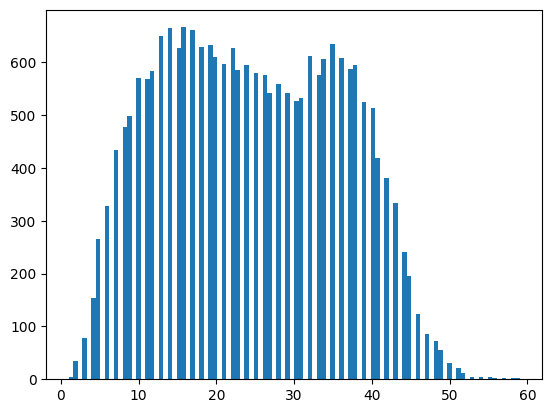

In [19]:
# Alumno: Determinar cual es la oración más larga

seqs_length = [len(s) for s in sequences]
print(f'el máximo es {max(seqs_length)}')

plt.figure()
plt.hist(seqs_length,bins=100)

In [20]:
# Alumno: Realizar padding de las sentencias al mismo tamaño
# tomando de referencia la máxima sentencia
from tensorflow.keras.utils import pad_sequences
maxlen = max(seqs_length)

X = pad_sequences(sequences, padding='pre', maxlen=maxlen)

In [21]:
# Alumno: Observar las dimensiones de la variable input
X.shape

(22641, 59)

In [22]:
# Alumno tomar la columna rating y alcemacenarla en una variable "y" transformada a oneHotEncoding
# Su shape debe ser equivalente la cantidad de rows del corpus y a la cantidad
# de clases que se deseen predecir (en este ejemplo son 5)
from keras.utils import to_categorical

y = df_reviews['Rating'].values
print(y.shape)

# Convert labels to one-hot encoding
y = to_categorical(y, num_classes=5)

(22641,)


In [23]:
# Alumno: Dividir los datos en train y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
# Alumno: determinar la dimensiones de entrada y salida
in_shape = X_train.shape[1] # max input sentence len
out_shape = 5 # categorical classification
print("in_shape", in_shape, ", out_shape", out_shape)

in_shape 59 , out_shape 5


### 2 - Entrenar el modelo con Embeddings + LSTM

In [25]:
# ! pip install tensorflow-addons

In [26]:
# Alumno: Entrene su modelo con LSTM entrenando sus propios embeddings
# o utilizando embeddings pre-entrenados.
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
import tensorflow_addons as tfa

model = Sequential()
# input_dim = vocab_size (max n_words)
# input_length = setencias con padding a 115
# output_dim = 50 --> crear embeddings de tamaño 50
model.add(Embedding(input_dim=vocab_size+1, output_dim=50, input_length=in_shape))
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=64)) # La última capa LSTM no lleva return_sequences

model.add(Dense(units=128, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units=out_shape, activation='softmax'))

model.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=[tfa.metrics.F1Score(num_classes=5, average='weighted')])

model.summary()

c:\Users\jonat\anaconda3\envs\nlp\Lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 59, 50)            100050    
                                                                 
 lstm (LSTM)                 (None, 59, 64)            29440     
                                                                 
 dropout (Dropout)           (None, 59, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 6

In [27]:
# ! pip install pydot graphviz 

In [28]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [29]:
hist = model.fit(X_train, y_train, epochs=10, validation_split=0.2)

Epoch 1/10
453/453 [==============================] - 15s 26ms/step - loss: 1.0186 - f1_score: 0.5120 - val_loss: 0.9446 - val_f1_score: 0.5506
Epoch 2/10
453/453 [==============================] - 11s 25ms/step - loss: 0.8734 - f1_score: 0.5949 - val_loss: 0.9594 - val_f1_score: 0.5736
Epoch 3/10
453/453 [==============================] - 11s 24ms/step - loss: 0.8098 - f1_score: 0.6384 - val_loss: 0.9257 - val_f1_score: 0.5907
Epoch 4/10
453/453 [==============================] - 11s 25ms/step - loss: 0.7574 - f1_score: 0.6629 - val_loss: 0.9400 - val_f1_score: 0.5892
Epoch 5/10
453/453 [==============================] - 11s 25ms/step - loss: 0.7150 - f1_score: 0.6852 - val_loss: 0.9903 - val_f1_score: 0.5893
Epoch 6/10
453/453 [==============================] - 11s 25ms/step - loss: 0.6832 - f1_score: 0.7006 - val_loss: 1.0848 - val_f1_score: 0.5759
Epoch 7/10
453/453 [==============================] - 12s 25ms/step - loss: 0.6479 - f1_score: 0.7221 - val_loss: 1.1043 - val_f1_score:

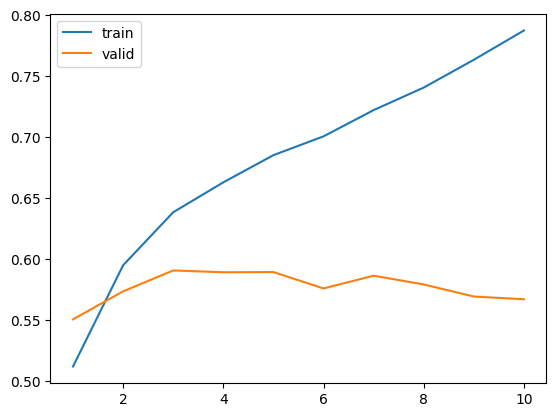

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
epoch_count = range(1, len(hist.history['f1_score']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['f1_score'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_f1_score'], label='valid')
plt.show()

In [31]:
model.evaluate(X_test, y_test)

142/142 [==============================] - 1s 9ms/step - loss: 1.2585 - f1_score: 0.5769


[1.2585315704345703, 0.5769361853599548]

### 3 - Entrenar el modelo con Embeddings Fasttext + LSTM

In [32]:
# Descargar los embeddings desde un gogle drive (es la forma más rápida)
# NOTA: No hay garantía de que estos links perduren, en caso de que no estén
# disponibles descargar de la página oficial como se explica en el siguiente bloque

if os.access('fasttext.pkl', os.F_OK) is False:
    url = 'https://drive.google.com/u/0/uc?id=1Qi1r-u5lsEsNqRSxLrpNOqQ3B_ufltCa&export=download&confirm=t'
    output = 'fasttext.pkl'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

El dataset ya se encuentra descargado


In [33]:
import logging
import os
from pathlib import Path
from io import StringIO
import pickle

class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dicctionarios para traducir de embedding a IDX de la palabra
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings


class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60


class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH = 'fasttext.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

In [34]:
model_fasttext = FasttextEmbeddings()

In [35]:
print('preparing embedding matrix...')
embed_dim = 300 # fasttext
words_not_found = []

# word_index proviene del tokenizer

nb_words = min(num_words, len(word_index)) # vocab_size
embedding_matrix = np.zeros((nb_words, embed_dim))

for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = model_fasttext.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        embedding_matrix[i] = embedding_vector
    else:
        # words que no estén en el índice de la matriz de embedding tendrán
        # como vector de embedding correspondiente todos ceros
        words_not_found.append(word)
        print(word)

print('number of null word embeddings:', np.sum(np.sum(embedding_matrix**2, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 2


In [36]:
# Definimos el modelo

model2 = Sequential()
# input_dim = vocab_size (max n_words)
# input_length = setencias con padding a 200
# output_dim = embed_dim (depende que embeddings pre entrenados utilizamos)
model2.add(Embedding(input_dim=vocab_size, # definido en el Tokenizador
                     output_dim=embed_dim, # dimensión de los embeddings utilizados
                     input_length=in_shape, # máxima sentencia de entrada
                     weights=[embedding_matrix], # matrix de embeddings
                    trainable=False)) # marcar como layer no entrenable

model2.add(LSTM(units=64, return_sequences=True))
model2.add(Dropout(0.2))
model2.add(LSTM(units=64)) # La última capa LSTM no lleva return_sequences

model2.add(Dense(units=128, activation='relu'))
model2.add(Dropout(rate=0.2))
model2.add(Dense(units=out_shape, activation='softmax'))

model2.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=[tfa.metrics.F1Score(num_classes=5, average='weighted')])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 59, 300)           600000    
                                                                 
 lstm_2 (LSTM)               (None, 59, 64)            93440     
                                                                 
 dropout_2 (Dropout)         (None, 59, 64)            0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dense_2 (Dense)             (None, 128)               8320      
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 5)                

In [37]:
hist2 = model2.fit(X_train, y_train, epochs=10, validation_split=0.2)

Epoch 1/10
453/453 [==============================] - 17s 31ms/step - loss: 1.2206 - f1_score: 0.3943 - val_loss: 1.2121 - val_f1_score: 0.3866
Epoch 2/10
453/453 [==============================] - 14s 32ms/step - loss: 1.1868 - f1_score: 0.3948 - val_loss: 1.1974 - val_f1_score: 0.3956
Epoch 3/10
453/453 [==============================] - 14s 32ms/step - loss: 1.1717 - f1_score: 0.4029 - val_loss: 1.1950 - val_f1_score: 0.3916
Epoch 4/10
453/453 [==============================] - 14s 32ms/step - loss: 1.1594 - f1_score: 0.4084 - val_loss: 1.1814 - val_f1_score: 0.4050
Epoch 5/10
453/453 [==============================] - 14s 32ms/step - loss: 1.1525 - f1_score: 0.4119 - val_loss: 1.1842 - val_f1_score: 0.4044
Epoch 6/10
453/453 [==============================] - 15s 32ms/step - loss: 1.1409 - f1_score: 0.4174 - val_loss: 1.1775 - val_f1_score: 0.4148
Epoch 7/10
453/453 [==============================] - 14s 32ms/step - loss: 1.1334 - f1_score: 0.4260 - val_loss: 1.1895 - val_f1_score:

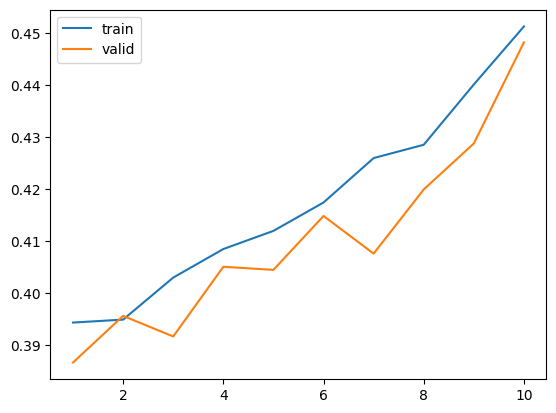

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
epoch_count = range(1, len(hist2.history['f1_score']) + 1)
sns.lineplot(x=epoch_count,  y=hist2.history['f1_score'], label='train')
sns.lineplot(x=epoch_count,  y=hist2.history['val_f1_score'], label='valid')
plt.show()

In [39]:
model2.evaluate(X_test, y_test)

142/142 [==============================] - 2s 13ms/step - loss: 1.1435 - f1_score: 0.4493


[1.1434786319732666, 0.44926661252975464]

# Conclusiones

- Las clases de "Rating" estaban desbalanceadas, por ende se optó utilizar el F1 score como métrica en vez de accuracy.
- El modelo con embeddings pre-entrenados tuvo menor F1 score pero menos overfitting, por lo que un modelo más complejo y con mayor cantidad de épocas podría superar al modelo con embeddings no pre-entrenados.